In [1]:
import os
VERSION = 9
if VERSION is not None:
    os.environ["CC"] = f"/usr/bin/gcc-{VERSION}"
    os.environ["CXX"] = f"/usr/bin/g++-{VERSION}"
from pathlib import Path
import sys
sys.path.append(str(Path(os.path.abspath('')).parent))
print(str(Path(os.path.abspath('')).parent))
import math
import torch
import matplotlib.pyplot as plt
import mediapy
from icecream import ic
from data import loader
import random
import time
from tqdm import tqdm
import numpy as np
from utils import cam_util
from utils.train_util import *
from models.ingp_density import Model, TetOptimizer
from fused_ssim import fused_ssim
from pathlib import Path, PosixPath
from utils.args import Args
import pickle
import json
from utils import safe_math
from delaunay_rasterization.internal.render_err import render_err
from delaunay_rasterization.internal.alphablend_tiled_slang import render_alpha_blend_tiles_slang_raw
from utils.train_util import render
import imageio

device = torch.device("cuda")
args = lambda x: x
args.dataset_path = Path("/optane/nerf_datasets/360/bicycle")
args.output_path = Path("output/test/")
args.image_folder = "images_4"
args.tile_size = 16
args.lambda_ssim = 0.0

train_cameras, test_cameras, scene_info = loader.load_dataset(
    args.dataset_path, args.image_folder, data_device="cuda", eval=True)

cmap = plt.get_cmap("jet")
path = Path(os.path.abspath('')).parent / "output/long_test_llr1e-2_decay0.1_nodelay_shint1k"
model = Model.load_ckpt(path, device)
torch.cuda.empty_cache()
# model = Model.load_ply(path, device)
camera = train_cameras[0]
target = camera.original_image.cuda()

/home/dronelab/delaunay_rasterization
Reading camera 194/194
Loaded Train Cameras: 169
Loaded Test Cameras: 25
Loaded 996389 vertices


/home/dronelab/miniconda3/envs/gaussian_splatting/lib/python3.11/site-packages/torch/_inductor/compile_fx.py:135: UserWarning: TensorFloat32 tensor cores for float32 matrix multiplication available but not enabled. Consider setting `torch.set_float32_matmul_precision('high')` for better performance.
  warnings.warn(
/home/dronelab/miniconda3/envs/gaussian_splatting/lib/python3.11/site-packages/torch/overrides.py:110: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  torch.has_cuda,
/home/dronelab/miniconda3/envs/gaussian_splatting/lib/python3.11/site-packages/torch/overrides.py:111: UserWarning: 'has_cudnn' is deprecated, please use 'torch.backends.cudnn.is_available()'
  torch.has_cudnn,
/home/dronelab/miniconda3/envs/gaussian_splatting/lib/python3.11/site-packages/torch/overrides.py:117: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  torch.has_mps,
/home/dronelab/miniconda3/envs/gaussian_splatting/lib/python3.11/s

/home/dronelab/miniconda3/envs/gaussian_splatting/lib/python3.11/site-packages/torch/utils/checkpoint.py:61: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/home/dronelab/miniconda3/envs/gaussian_splatting/lib/python3.11/site-packages/torch/utils/checkpoint.py:61: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/home/dronelab/miniconda3/envs/gaussian_splatting/lib/python3.11/site-packages/torch/utils/checkpoint.py:61: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


torch.Size([822, 1237])


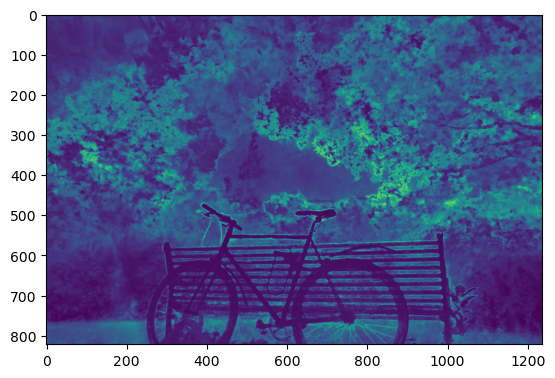

In [2]:
with torch.no_grad():
    render_pkg = render(camera, model)
    print(render_pkg['distortion_img'].shape)
    plt.imshow(render_pkg['distortion_img'].detach().cpu().numpy())
    plt.show()


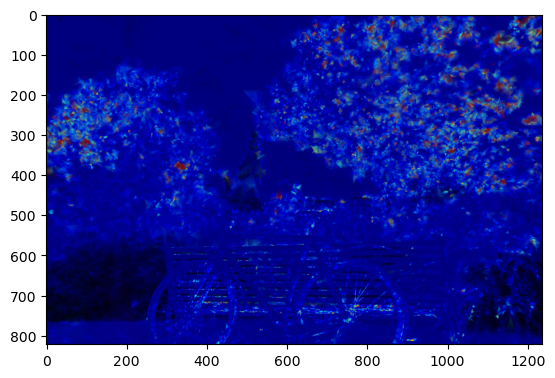

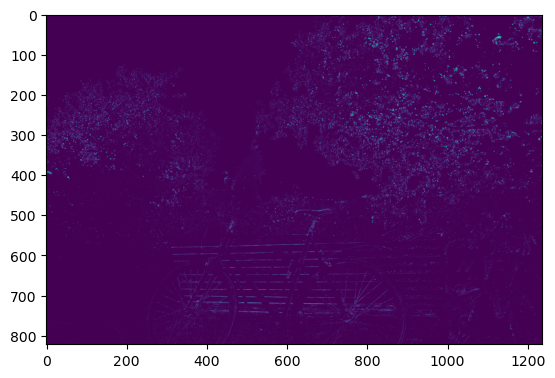

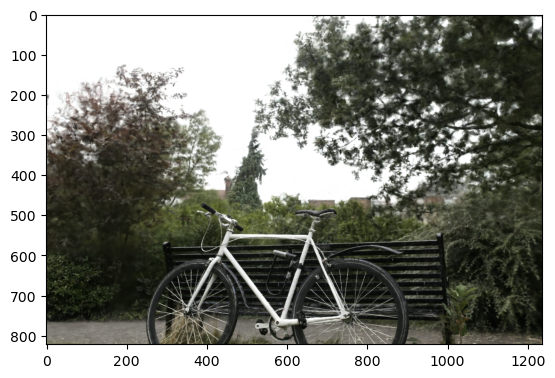

In [3]:

def disp(im):
    im = (im.detach().cpu().numpy() * 255).clip(min=0, max=255).astype(np.uint8)
    plt.imshow(im)
    plt.show()


with torch.no_grad():
    tet_rgbs_grad, render_pkg2 = render_err(target, camera, model, tile_size=args.tile_size, lambda_ssim=args.lambda_ssim)
    # tet_rgbs_grad = update_rgbs(tet_rgbs_grad, tet_grad, render_pkg['tet_area'])

with torch.no_grad():
    render_tensor = tet_rgbs_grad
    tensor_min, tensor_max = render_tensor.min(), render_tensor.max()
    normalized_tensor = (render_tensor - tensor_min) / (tensor_max - tensor_min)

    # Convert to RGB (NxMx3) using the colormap
    tet_grad_color = torch.as_tensor(cmap(normalized_tensor.cpu().numpy())).float().cuda()
    _, densities = model.get_cell_values(camera)
    tet_grad_color[:, 3] = densities
    render_pkg = render_alpha_blend_tiles_slang_raw(model.indices, model.vertices, None, camera, cell_values=tet_grad_color)
    # tensor_min, tensor_max = tet_rgbs_grad.min(), tet_rgbs_grad.max()
    # normalized_tensor = (tet_rgbs_grad - tensor_min) / (tensor_max - tensor_min)

    # # Convert to RGB (NxMx3) using the colormap
    # tet_grad_color = torch.as_tensor(cmap(normalized_tensor.cpu().numpy())).float().cuda()
    # tet_grad_color[:, 3] = model.get_cell_values(camera)[:, 3]
    # render_pkg = render(camera, model, cell_values=tet_grad_color, tile_size=args.tile_size)

    image = render_pkg['render']
    image = image.permute(1, 2, 0)
    disp(image)
    disp(render_pkg2['pixel_err'])
    disp(render_pkg2['render_img'].permute(1, 2, 0))